# Regression Project

The main goal of the project: pick a regression model and find the best
RMSE given train data (X and y) and given the X of the test data. The y of the test data is not given. 

In [553]:
# Imports:
import pandas as pd
import numpy as np
from scipy import stats # for Z scores
import seaborn as sns # Correlation matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler # for one-hot encoding in regression and data normalization
from sklearn.metrics import mean_squared_error
import json

# import pydot
# from IPython.display import Image
# from six import StringIO
# from sklearn.tree import export_graphviz

In [554]:
X_train = pd.read_csv("X.csv")
X_train.head(4)

,Unnamed: 0.1,Unnamed: 0,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,id,professionalism
0,2477,2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,2477,1150.0
1,76,76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,76,1100.0
2,64,64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,64,26.0
3,924,924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,924,279.0


In [555]:
X_train.shape

(5363, 13)

Check if the columns are duplicates

In [556]:
X_train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Age', 'Gender', 'Education Level',
       'Job Title', 'Years of Experience', 'Country', 'Race', 'height',
       'weight', 'id', 'professionalism'],
      dtype='object')

In [557]:
# Check if 'Unnamed: 0', 'Unnamed: 0.1' and 'id' are duplicates
are_columns_duplicates_1_2 = (X_train['Unnamed: 0'] == X_train['Unnamed: 0.1']).all()
are_columns_duplicates_1_id = (X_train['Unnamed: 0'] == X_train['id']).all()
are_columns_duplicates_2_id = (X_train['Unnamed: 0.1'] == X_train['id']).all()

# Drop 'Unnamed: 0' and 'Unnamed: 0.1' if they are duplicates of 'id'
if are_columns_duplicates_1_2 and are_columns_duplicates_1_id and are_columns_duplicates_2_id:
    X_train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [558]:
X_train.head(4)

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,id,professionalism
0,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,2477,1150.0
1,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,76,1100.0
2,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,64,26.0
3,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,924,279.0


In [559]:
X_train.shape  # changed from (5363, 13) to (5363, 11)

(5363, 11)

In [560]:
# Get the info of each column
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5359 non-null   float64
 1   Gender               5359 non-null   object 
 2   Education Level      5360 non-null   object 
 3   Job Title            5361 non-null   object 
 4   Years of Experience  5360 non-null   float64
 5   Country              5363 non-null   object 
 6   Race                 5363 non-null   object 
 7   height               5363 non-null   float64
 8   weight               5361 non-null   float64
 9   id                   5363 non-null   int64  
 10  professionalism      5360 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 461.0+ KB


In [561]:
# Find rows where any cell has a null value
rows_with_null = X_train[X_train.isna().any(axis=1)]
print(len(rows_with_null))

6


In [562]:
# 

In [563]:
# Consider dropping those rows
print(set(X_train['Gender']))
rows_with_O = X_train[X_train['Gender'] == 'O']
print(len(rows_with_O))

{'O', 'M', nan, 'F'}
12


In [564]:
# Remove all rows with any missing values (as they are only 6 rows out of 5363 rows):
X_train.dropna(inplace=True)

In [565]:
# X_train = X_train[X_train['Gender'] != 'O'] we can't remove them as they are included in the submission test

In [566]:
X_train.shape  # changed from (5363, 13) to (5343, 11)

(5357, 11)

In [567]:
y_train = pd.read_csv("y.csv")
y_train.head(4)
# print(y_train.shape)  # (5363, 2)

,id,Salary
0,2477,175966.0
1,76,160000.0
2,64,35000.0
3,924,195000.0


In [568]:
y_train.info()  # we have all ids, but 5 of them have null Salary value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      5363 non-null   int64  
 1   Salary  5358 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 83.9 KB


In [569]:
rows_with_null_y = y_train[y_train.isna().any(axis=1)]
print(rows_with_null_y)

        id  Salary
1138  3136     NaN
1309   172     NaN
3071  5247     NaN
4110   260     NaN
5077  6455     NaN


In [570]:
# Remove 5 rows with missing salary value:
y_train.dropna(inplace=True)

In [571]:
# Filter the data frames to only include 'id' values that are present in both:
common_ids = set(X_train['id']) & set(y_train['id'])

X_train = X_train[X_train['id'].isin(common_ids)]
y_train = y_train[y_train['id'].isin(common_ids)] 

print(X_train.shape, y_train.shape)

(5355, 11) (5355, 2)


In [572]:
# set(X_train['Gender'])
# set(X_train['Education Level'])
# set(X_train['Job Title'])
# set(X_train['Country'])
# set(X_train['Race']) 

In [573]:
# Columns of interest
object_columns = ['Gender', 'Education Level', 'Job Title', 'Country', 'Race']

# Loop through and print unique values
for column in object_columns:
    unique_values = set(X_train[column])
    print(f"Unique values in {column}:")
    print(", ".join([str(x) for x in unique_values]))
    print('-' * 50)

Unique values in Gender:
M, O, F
--------------------------------------------------
Unique values in Education Level:
bachelor, master, bachelor's|degr, high|scho, p, master's|degr
--------------------------------------------------
Unique values in Job Title:
help|desk|analys, digital|content|produce, ce, social|media|specialis, director|of|financ, junior|designe, customer|success|re, junior|financial|analys, customer|service|manage, director|of|data|scienc, marketing|analys, junior|operations|analys, junior|project|manage, it|support|specialis, accountan, junior|copywrite, junior|research|scientis, technical|write, senior|human|resources|manage, data|scientis, project|manage, vp|of|financ, junior|marketing|coordinato, hr|manage, junior|data|analys, senior|marketing|coordinato, director|of|operation, senior|data|analys, business|analys, senior|data|scientis, junior|web|develope, senior|product|manage, junior|software|enginee, junior|marketing|manage, marketing|directo, junior|product|m

More Data Processing

In [574]:
# Combine X_train and y_train based on 'id'
combined_df = pd.merge(X_train, y_train, on='id', how='inner')

In [575]:
combined_df.shape #(5343, 15)

(5355, 12)

In [576]:
# Remove outliers with Z-Score Method (defined by z-score greater than 3)

# Calculate the z-scores
z_scores = np.abs(stats.zscore(combined_df['Salary']))

# Define a threshold for identifying outliers 
threshold = 3

# Get boolean array where True indicates the presence of an outlier
outliers = (z_scores >= threshold)

# Count the number of outliers
num_outliers = np.sum(outliers)

# Filter out the outliers
filtered_entries = (z_scores < threshold)

# Create a DataFrame without outliers
combined_df = combined_df[filtered_entries]

# Print the number of outliers removed
print(f"Number of outliers removed: {num_outliers}")

Number of outliers removed: 0


Numerical Feature Selection with Correlation Matrix 

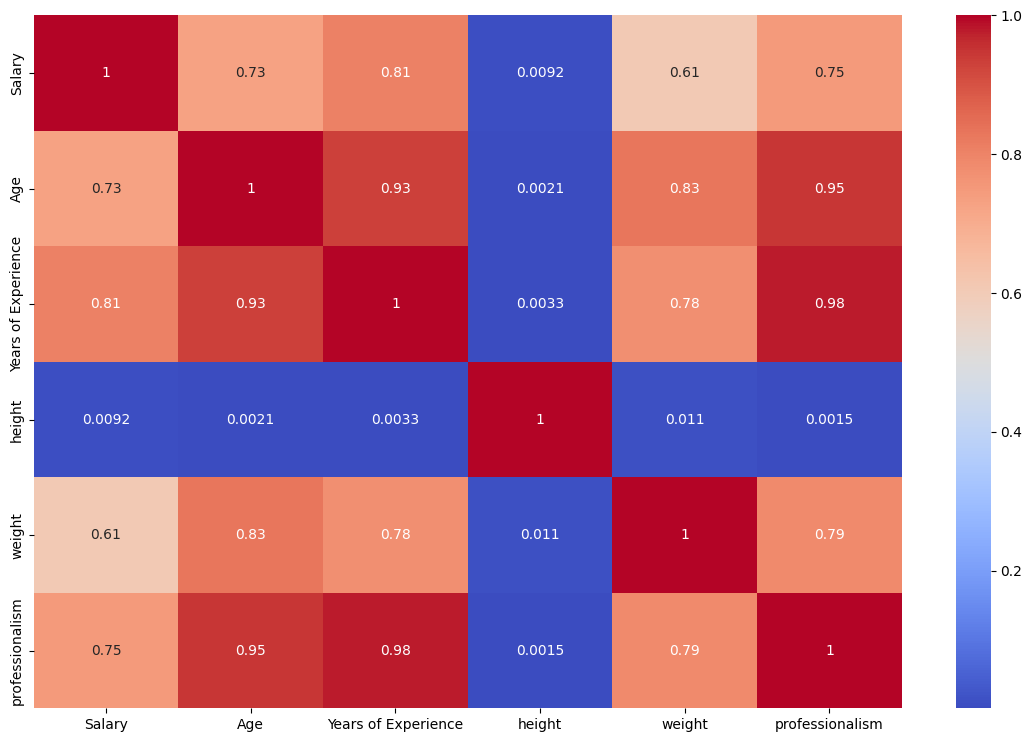

In [577]:
# Select numerical features of interest
selected_features = ['Salary', 'Age', 'Years of Experience', 'height', 'weight', 'professionalism']

# Create a correlation matrix
corr_matrix = combined_df[selected_features].corr()

# Plot the heatmap for visualization
plt.figure(figsize=(14, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Interim conclusion:
1. The 'height' features seems uninformative given the low correlation with 'Salary'(0.0091)
2. 'Age', 'professionalism' and 'Years of Experience' are strongly correlated, possibly providing similar information (collinear variables?)
3. I'll drop 'Professionalism' and 'height'

Handling categorical features before performing features selection
1. We will model only gender = 'F' or Gender ='M', as there are very few 'O' and we want to reduce complexity
2. There are too many job titles which could be grouped together by essential information (e.g.: 'Manager', 'Engineer')
3. Education Level could also be recoded to express rank

In [578]:
# Mapping
# I assume 'p' stands for something beyond masters given the mean salary and years of experience
education_mapping = {
    'high|scho': 'High School',
    'p': 'PhD/Professional',
    'bachelor': 'Bachelors',
    "bachelor's|degr": 'Bachelors',
    'master': 'Masters',
    "master's|degr": 'Masters'
}

# Create a new education level column with cleaned-up labels
combined_df['New Education Level'] = combined_df['Education Level'].map(education_mapping)

In [579]:
## Unique values in Education Level: high|scho, p, bachelor's|degr, bachelor, master, master's|degr
# The values for mean salary and mean years of experience indicae that 'p' is probably above 'Masters'
grouped1 = combined_df.groupby('New Education Level')['Salary'].mean()
grouped2 = combined_df.groupby('New Education Level')['Years of Experience'].mean()
print('Mean Salary')
print(grouped1)
print('**********'*4)
print('Mean Years of Experience')
print(grouped2)

Mean Salary
New Education Level
Bachelors            95478.581654
High School          37536.548961
Masters             129799.460570
PhD/Professional    165708.206865
Name: Salary, dtype: float64
****************************************
Mean Years of Experience
New Education Level
Bachelors            6.973468
High School          3.569733
Masters             11.134526
PhD/Professional    15.361781
Name: Years of Experience, dtype: float64


In [580]:
# Mean salary for each job title
mean_salary_by_title = combined_df.groupby('Job Title')['Salary'].mean().reset_index()
mean_salary_by_title = mean_salary_by_title.sort_values('Salary')
mean_salary_by_title.head(3)

,Job Title,Salary
102,receptionis,25000.000000
20,delivery|drive,28000.000000
75,junior|sales|associat,28296.296296


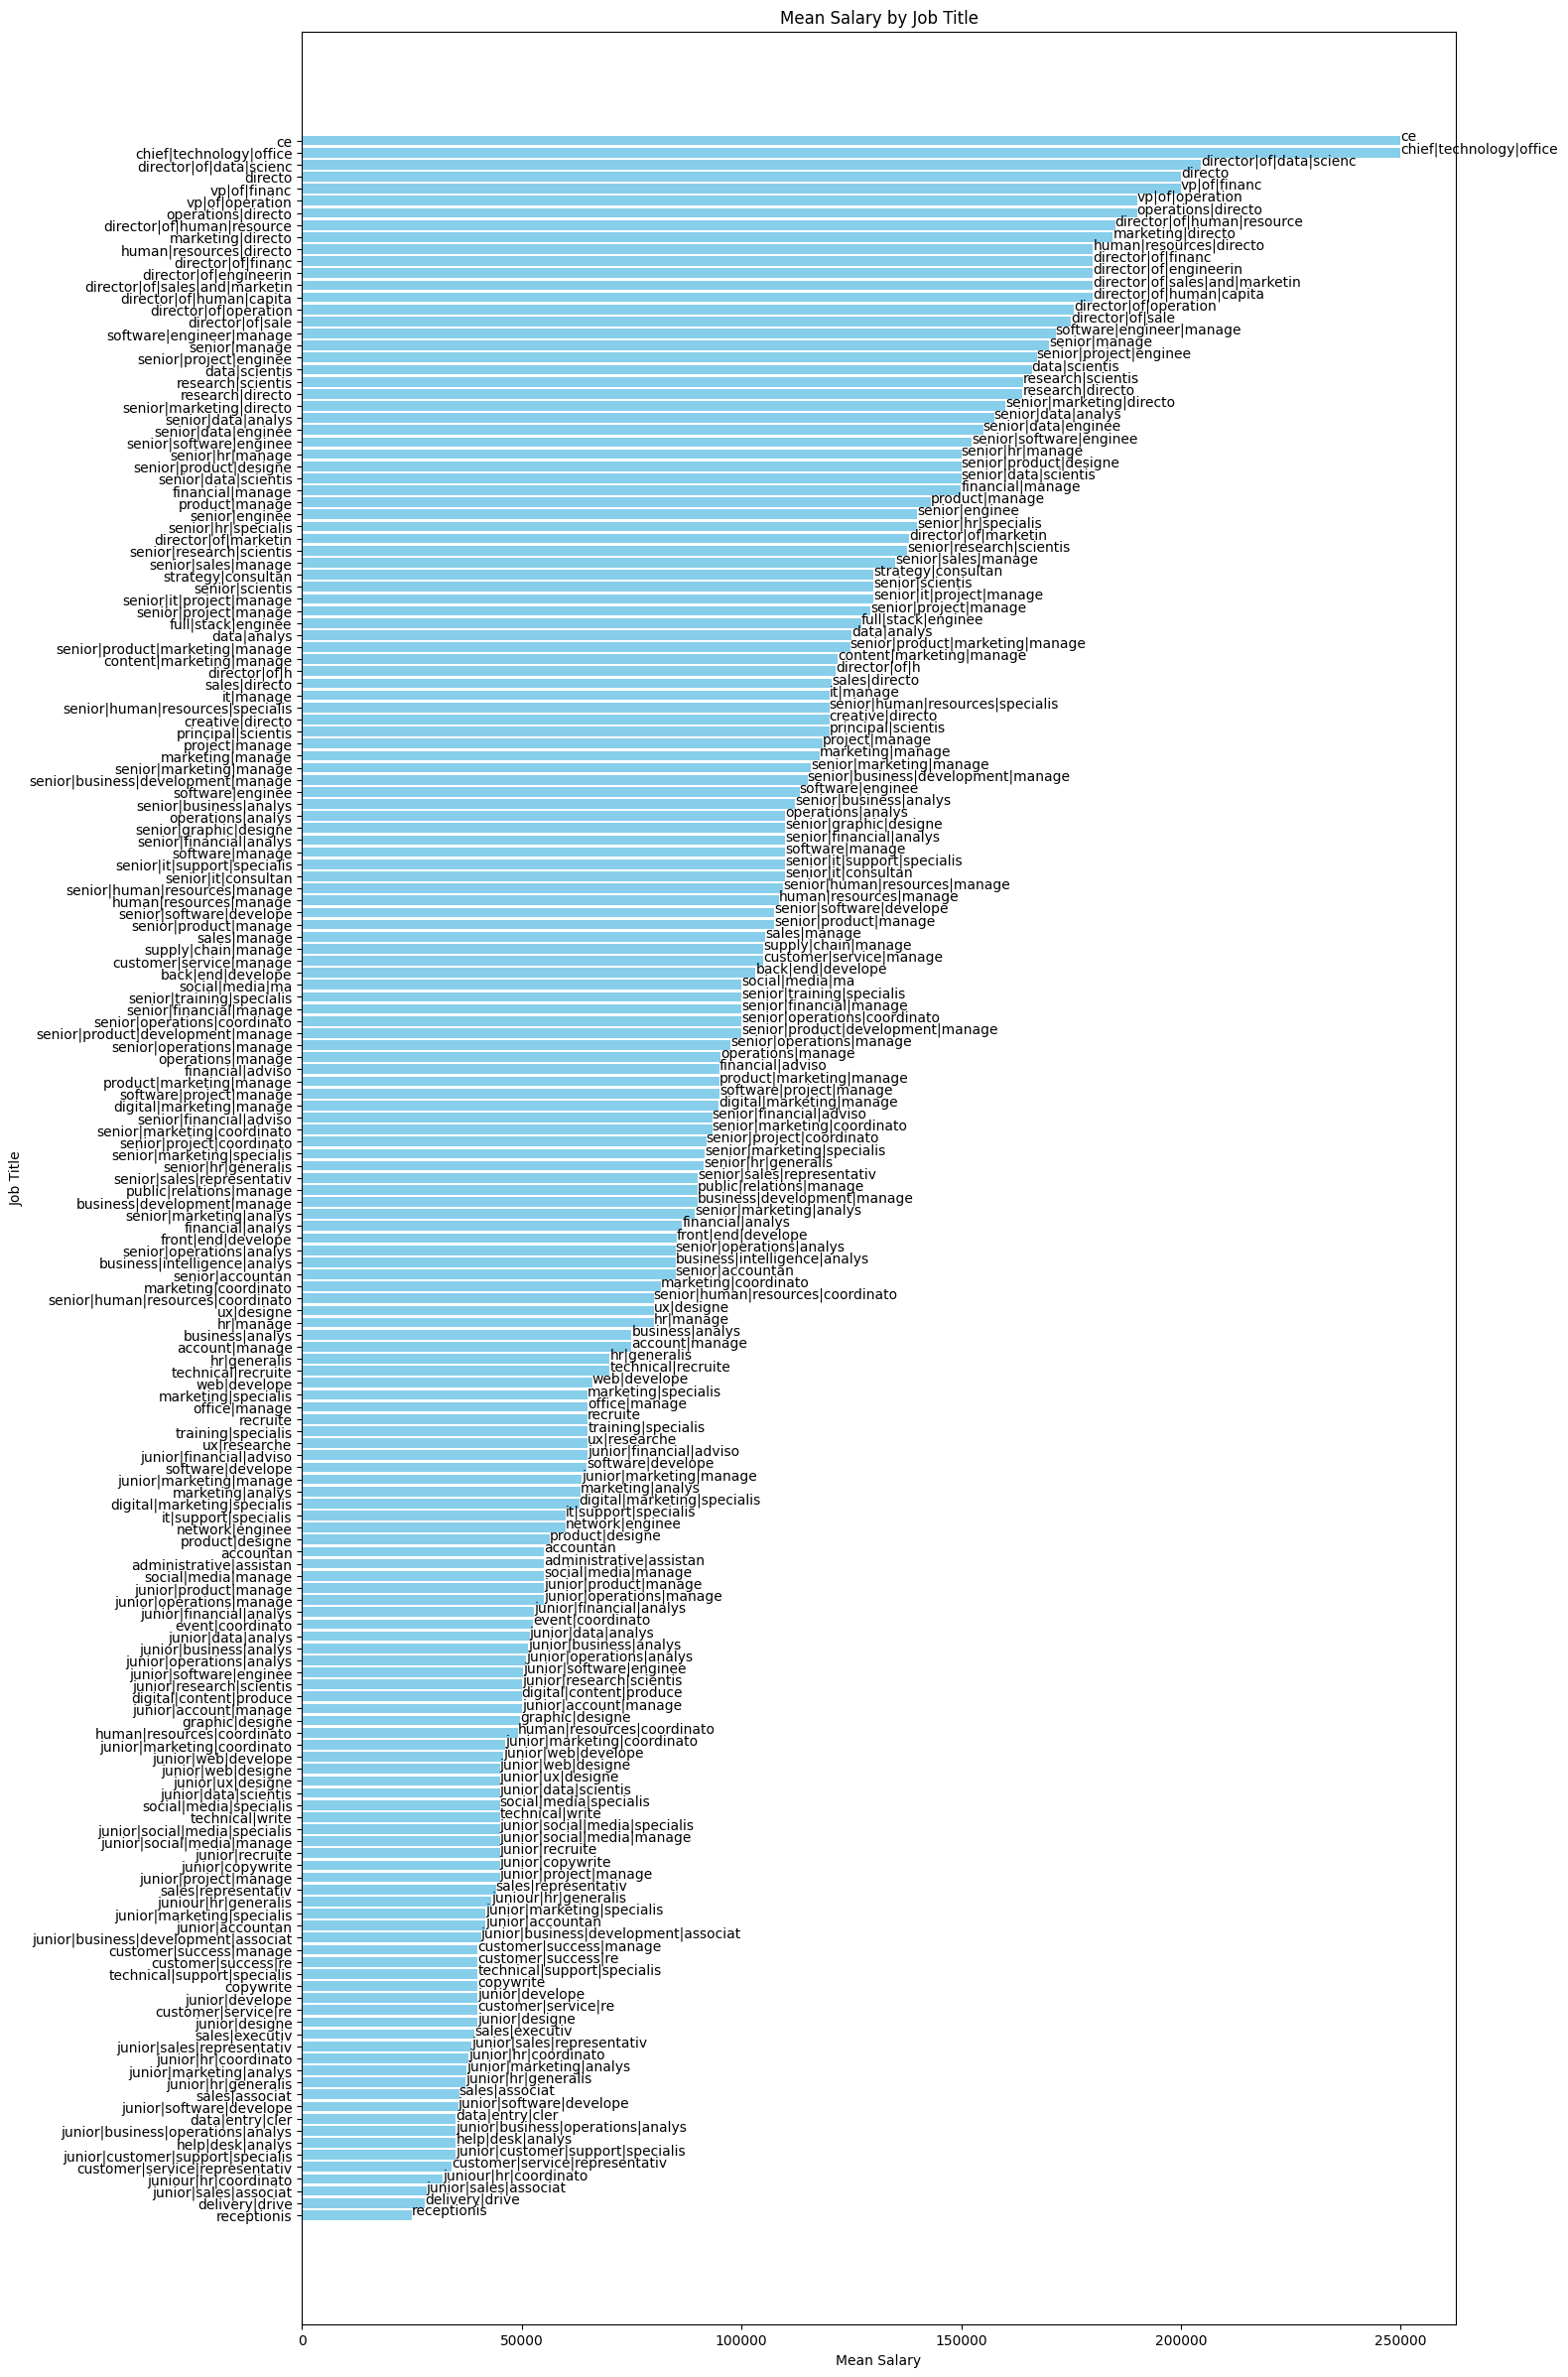

In [581]:
#Histogram of the mean salaries
plt.figure(figsize=(15, 30))  # set the figure size
plt.barh(mean_salary_by_title['Job Title'], mean_salary_by_title['Salary'], color='skyblue')

# Annotate each bar with the respective job title
for index, value in enumerate(mean_salary_by_title['Salary']):
    plt.text(value, index, str(mean_salary_by_title['Job Title'].iloc[index]))

plt.xlabel('Mean Salary')
plt.ylabel('Job Title')
plt.title('Mean Salary by Job Title')

plt.show()

# Looks like we can differentiate between director, senior, junior and other. The problem is that 'other' will include
# jobs with very high salary and vey low salary, so we might be losing data
# this is why  I think that we should use one-hot encoding and not label-encoding

In [582]:
# transforming the 'Job Title' based on salary quintiles to generate a more informative feature

# Step 1: Sort by Salary and divide into 6 quintiles
combined_df = combined_df.sort_values(by='Salary')
combined_df['Salary_Quintile'] = pd.qcut(combined_df['Salary'], 6, labels=[1, 2, 3, 4, 5, 6])

# Initialize an empty dictionary to hold word counts for each quintile
word_count_by_quintile = {}

# Step 2-5: Count word frequency per quintile
for quintile in [1, 2, 3, 4, 5, 6]:
    job_titles = combined_df[combined_df['Salary_Quintile'] == quintile]['Job Title']
    words = ' '.join(job_titles.str.replace('|', ' ')).split(' ')
    word_count = Counter(words)
    top_5_words = word_count.most_common(6)
    print(top_5_words)

# This shows some words appear across many quintiles, thus they are not good for separation: software, engineer, manager

[('junior', 388), ('sales', 256), ('associat', 169), ('develope', 162), ('software', 145), ('manage', 97)]
[('develope', 250), ('marketing', 226), ('software', 222), ('manage', 202), ('enginee', 178), ('end', 161)]
[('manage', 240), ('enginee', 195), ('senior', 185), ('marketing', 174), ('analys', 167), ('develope', 147)]
[('manage', 317), ('enginee', 181), ('data', 174), ('senior', 140), ('marketing', 136), ('scientis', 132)]
[('enginee', 304), ('software', 299), ('manage', 234), ('scientis', 226), ('senior', 225), ('data', 221)]
[('manage', 321), ('enginee', 242), ('software', 233), ('senior', 195), ('data', 186), ('engineer', 151)]


In [583]:
def group_job_titles(title):
    if 'sales' in title.lower():
        return 'Sales'
    elif 'marketing' in title.lower():
        return 'Marketing'
    elif 'data' in title.lower():
        return 'Data'
    elif 'coordinato' in title.lower():
        return 'Coordinator'
    elif 'scientis' in title.lower():
        return 'Scientist'
    elif 'full' in title.lower():
        return 'Full Stack'
    elif 'project' in title.lower():
        return 'Project Manager'
    else:
        return 'Other'

combined_df['Grouped Job Title'] = combined_df['Job Title'].apply(group_job_titles)

In [584]:
# # This filtering is optional:
# count_other = len(combined_df[combined_df['Grouped Job Title'] == 'Other'])
# print(f"The number of rows with 'Grouped Job Title' as 'Other': {count_other}")

# # Get rid of jobs that are difficult to classify
# combined_df = combined_df[combined_df['Grouped Job Title'] != 'Other']

In [585]:
combined_df.head(2)

,Age,Gender,Education Level,Job Title,Years of Experience,...,professionalism,Salary,New Education Level,Salary_Quintile,Grouped Job Title
2385,33.0,F,bachelor's|degr,junior|hr|coordinato,6.0,...,124.0,500.0,Bachelors,1,Coordinator
2066,27.0,F,bachelor's|degr,front|end|develope,2.0,...,25.0,550.0,Bachelors,1,Other


In [586]:
combined_df.groupby('Grouped Job Title')['Salary'].mean()

Grouped Job Title
Coordinator         50900.000000
Data               148856.000000
Full Stack         127233.722892
Marketing          102202.412869
Other              112196.877149
Project Manager    161527.810169
Sales               56804.034582
Scientist          151089.108911
Name: Salary, dtype: float64

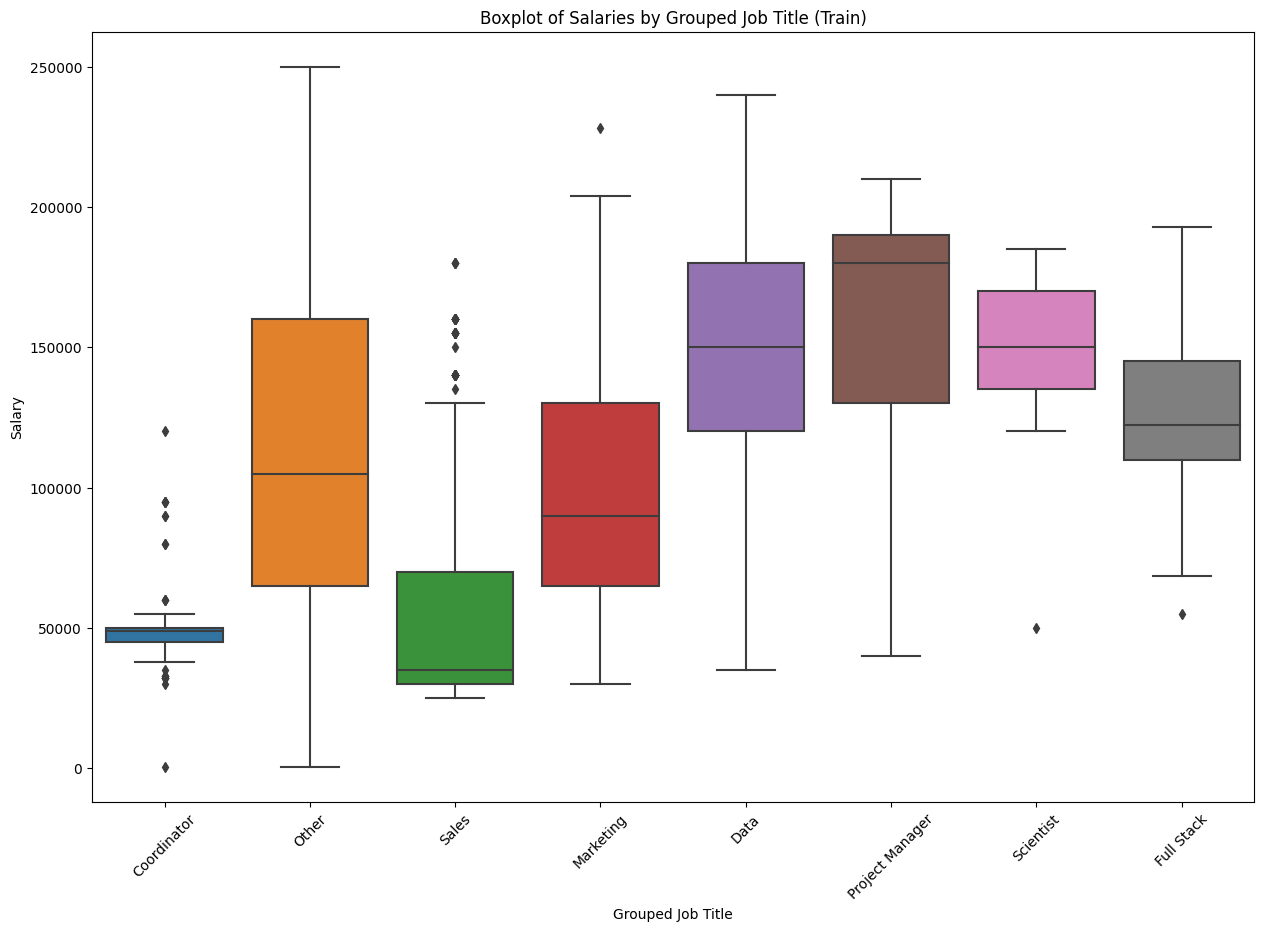

In [587]:
# Create a boxplot 
# As expected, the 'other' group is very variable and probably needs more grouping
plt.figure(figsize=(15, 10))
sns.boxplot(x='Grouped Job Title', y='Salary', data=combined_df)
plt.title("Boxplot of Salaries by Grouped Job Title (Train)")
plt.xticks(rotation=45)
plt.show()

Regression Tree Model

In [588]:
# Define features type (numerical or categorical)
numerical_cols = ['Age', 'Years of Experience','weight']
categorical_cols = ['Gender', 'Grouped Job Title', 'New Education Level','Country', 'Race'] 

# One-hot encode the categorical data
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(combined_df[categorical_cols])

# Create a DataFrame from the encoded data, with correct column names
encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with numerical data
final_df = pd.concat([encoded_df.reset_index(drop=True), combined_df[numerical_cols].reset_index(drop=True)], axis=1)

# Create Decision Tree model
model = DecisionTreeRegressor(max_leaf_nodes=30)

# Fit model
model.fit(final_df, combined_df['Salary'])

# If you want to see feature importance
feature_importances = model.feature_importances_
feature_names = final_df.columns
sorted_idx = feature_importances.argsort()

# Sort features by importance and create a DataFrame
sorted_features = [(feature_names[i], feature_importances[i]) for i in sorted_idx]
sorted_features_df = pd.DataFrame(sorted(sorted_features, key=lambda x: x[1], reverse=True), columns=['Feature', 'Importance'])

# Show the DataFrame
print(sorted_features_df)

                                 Feature  Importance
0                    Years of Experience    0.863456
1                 Grouped Job Title_Data    0.060835
2                                    Age    0.032207
3        New Education Level_High School    0.017732
4            Grouped Job Title_Marketing    0.008452
5          New Education Level_Bachelors    0.006610
6                               Gender_M    0.005067
7   New Education Level_PhD/Professional    0.001937
8      Grouped Job Title_Project Manager    0.001863
9                Grouped Job Title_Other    0.001841
10                              Gender_F    0.000000
11                            Race_White    0.000000
12                            Race_Welsh    0.000000
13                            Race_Mixed    0.000000
14                           Race_Korean    0.000000
15                         Race_Hispanic    0.000000
16                          Race_Chinese    0.000000
17                            Race_Black    0.

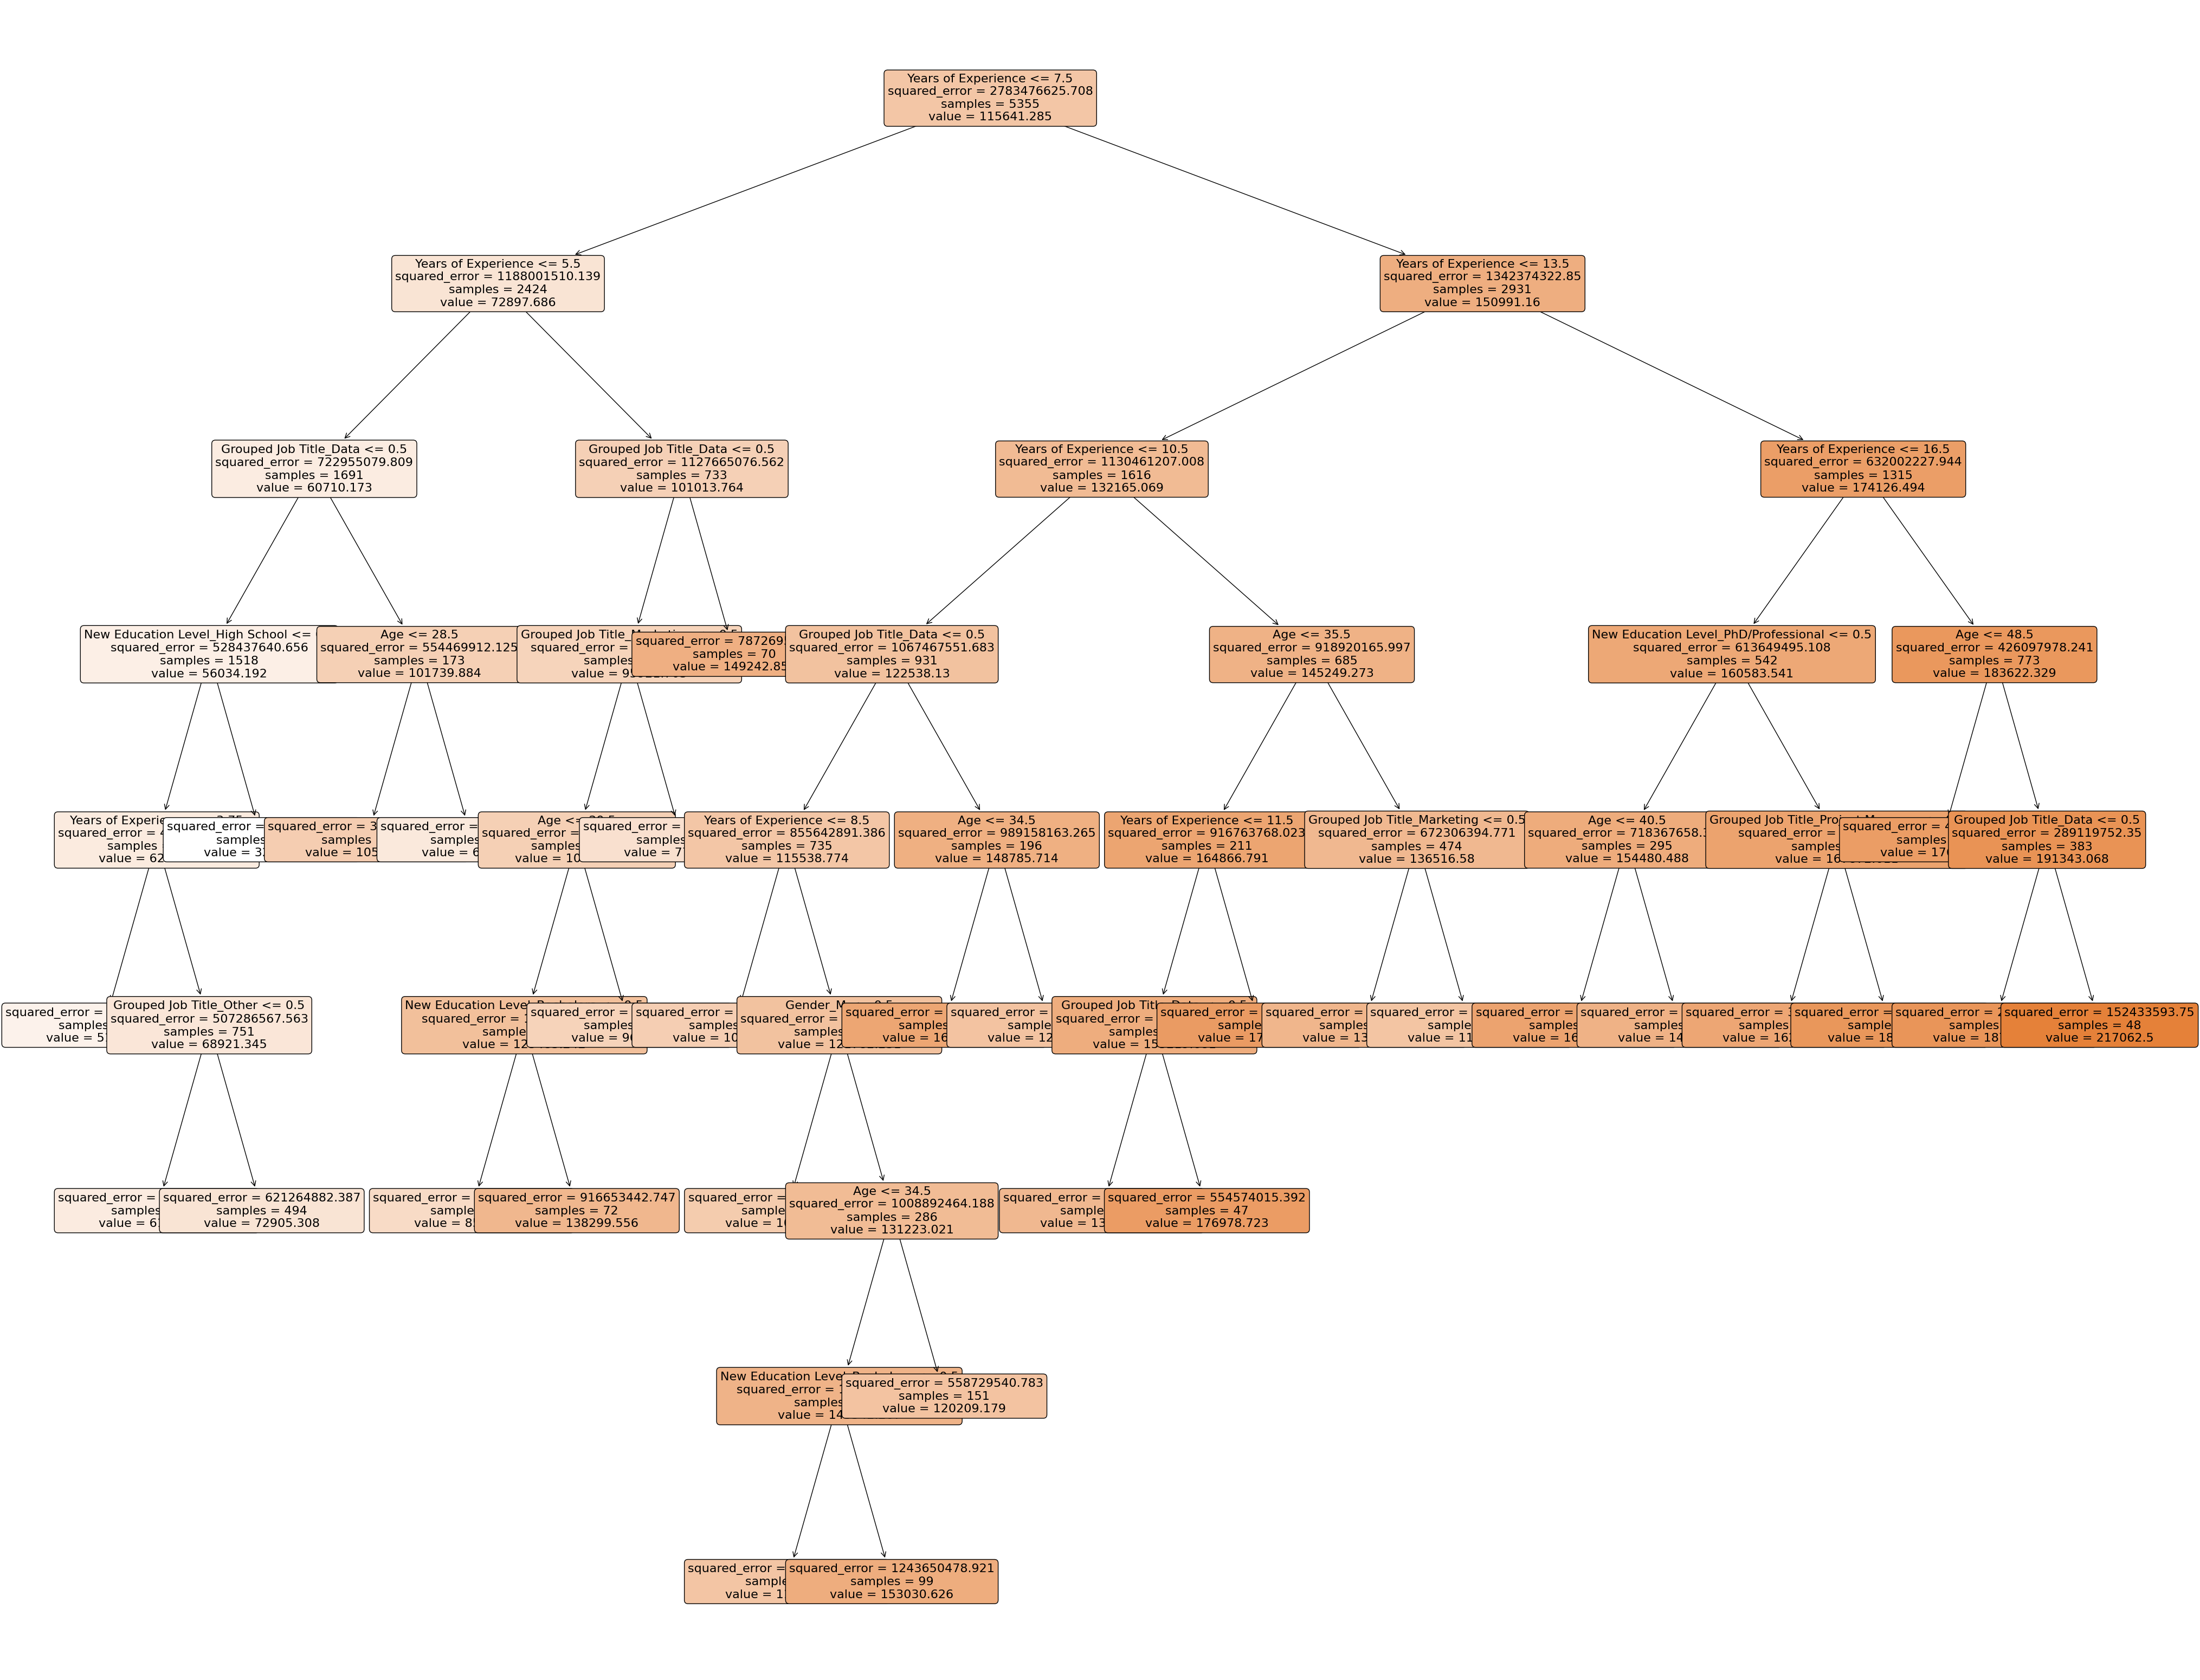

In [589]:
plt.figure(figsize=(50,40))  # Set the figure size
plot_tree(model, 
          feature_names=feature_names.tolist(),  # One-hot encoded feature names
          filled=True, 
          rounded=True, 
          fontsize=16)
plt.show()

Interim conclusions:
1. Country, Race and weight might be irrelevant/uninformative
2. Consider better grouping of the 'Job Title' feature
3. Repeat the model with fewer features without: Country, Race and weight (use the first tree model for further features selection)

Second Regression Tree model

In [590]:
# Define features type (numerical or categorical)
numerical_cols = ['Age', 'Years of Experience']
categorical_cols = ['Gender', 'Grouped Job Title', 'New Education Level'] 

# One-hot encode the categorical data
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(combined_df[categorical_cols])

# Create a DataFrame from the encoded data, with correct column names
encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with numerical data
final_df = pd.concat([encoded_df.reset_index(drop=True), combined_df[numerical_cols].reset_index(drop=True)], axis=1)

# Create Decision Tree model
model = DecisionTreeRegressor(max_leaf_nodes=30)

# Fit model
model.fit(final_df, combined_df['Salary'])

# If you want to see feature importance
feature_importances = model.feature_importances_
feature_names = final_df.columns
sorted_idx = feature_importances.argsort()

# Sort features by importance and create a DataFrame
sorted_features = [(feature_names[i], feature_importances[i]) for i in sorted_idx]
sorted_features_df = pd.DataFrame(sorted(sorted_features, key=lambda x: x[1], reverse=True), columns=['Feature', 'Importance'])

# Show the DataFrame
print(sorted_features_df)

                                 Feature  Importance
0                    Years of Experience    0.863456
1                 Grouped Job Title_Data    0.060835
2                                    Age    0.032207
3        New Education Level_High School    0.017732
4            Grouped Job Title_Marketing    0.008452
5          New Education Level_Bachelors    0.006610
6                               Gender_M    0.005067
7   New Education Level_PhD/Professional    0.001937
8      Grouped Job Title_Project Manager    0.001863
9                Grouped Job Title_Other    0.001841
10                              Gender_F    0.000000
11           New Education Level_Masters    0.000000
12                              Gender_O    0.000000
13         Grouped Job Title_Coordinator    0.000000
14           Grouped Job Title_Scientist    0.000000
15          Grouped Job Title_Full Stack    0.000000
16               Grouped Job Title_Sales    0.000000


Model Evaluation (Train Dataset)

In [591]:
# Make predictions on the training set
y_train_pred = model.predict(final_df)

# Name the y train data
y_train = combined_df['Salary']

# Calculate RMSE for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Root Mean Square Error on training data: {rmse_train}')

Root Mean Square Error on training data: 21427.663101097292


In [592]:
# feature_importance = pd.Series(lasso_coef, index=final_df.columns)
# feature_importance = feature_importance.sort_values()

# feature_importance.plot(kind='barh')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.show()


Process, Encode and Model the Test Dataset

In [593]:
X_test = pd.read_csv("X_test.csv")
print(X_test.shape)
X_test.head(2)

(1341, 13)


,Unnamed: 0.1,Unnamed: 0,Age,Gender,Education Level,...,Race,height,weight,id,professionalism
0,6480,6480,47.0,M,master's|degr,...,Hispanic,1.818297,88.182651,6480,675.0
1,5343,5343,29.0,F,bachelor's|degr,...,African American,1.562833,59.760856,5343,81.0


In [594]:
# Check if 'Unnamed: 0', 'Unnamed: 0.1' and 'id' are duplicates
are_columns_duplicates_1_2 = (X_test['Unnamed: 0'] == X_test['Unnamed: 0.1']).all()
are_columns_duplicates_1_id = (X_test['Unnamed: 0'] == X_test['id']).all()
are_columns_duplicates_2_id = (X_test['Unnamed: 0.1'] == X_test['id']).all()

# Drop 'Unnamed: 0' and 'Unnamed: 0.1' if they are duplicates of 'id'
if are_columns_duplicates_1_2 and are_columns_duplicates_1_id and are_columns_duplicates_2_id:
    X_test.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [595]:
# X_test = X_test[X_test['Gender'] != 'O'] we can't remove them as they are included in the submission test

In [596]:
X_test.shape  # changed from (1341, 13) to (1341, 11)
X_test.info() # X test has no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1341 non-null   float64
 1   Gender               1341 non-null   object 
 2   Education Level      1341 non-null   object 
 3   Job Title            1341 non-null   object 
 4   Years of Experience  1341 non-null   float64
 5   Country              1341 non-null   object 
 6   Race                 1341 non-null   object 
 7   height               1341 non-null   float64
 8   weight               1341 non-null   float64
 9   id                   1341 non-null   int64  
 10  professionalism      1341 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 115.4+ KB


In [597]:
y_test = pd.read_csv("y_test.csv")
y_test.head(2)

,Unnamed: 0,id,Salary
0,0,6480,25465.0
1,1,5343,166574.0


In [598]:
print(y_test.shape)  # (1341, 3)
print(y_test.info())  # no missing values

(1341, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1341 non-null   int64  
 1   id          1341 non-null   int64  
 2   Salary      1341 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 31.6 KB
None


In [599]:
# Combine X_test and y_test based on 'id'
combined_df_test = pd.merge(X_test, y_test, on='id', how='inner')
combined_df_test = combined_df_test.drop(['Unnamed: 0'], axis=1)
combined_df_test.head(2)

,Age,Gender,Education Level,Job Title,Years of Experience,...,height,weight,id,professionalism,Salary
0,47.0,M,master's|degr,director|of|marketin,16.0,...,1.818297,88.182651,6480,675.0,25465.0
1,29.0,F,bachelor's|degr,social|media|manage,4.0,...,1.562833,59.760856,5343,81.0,166574.0


In [600]:
# Create a new education level column with cleaned-up labels
combined_df_test['New Education Level'] = combined_df_test['Education Level'].map(education_mapping)
combined_df_test['Grouped Job Title'] = combined_df_test['Job Title'].apply(group_job_titles)
combined_df_test.head(2)

,Age,Gender,Education Level,Job Title,Years of Experience,...,id,professionalism,Salary,New Education Level,Grouped Job Title
0,47.0,M,master's|degr,director|of|marketin,16.0,...,6480,675.0,25465.0,Masters,Other
1,29.0,F,bachelor's|degr,social|media|manage,4.0,...,5343,81.0,166574.0,Bachelors,Other


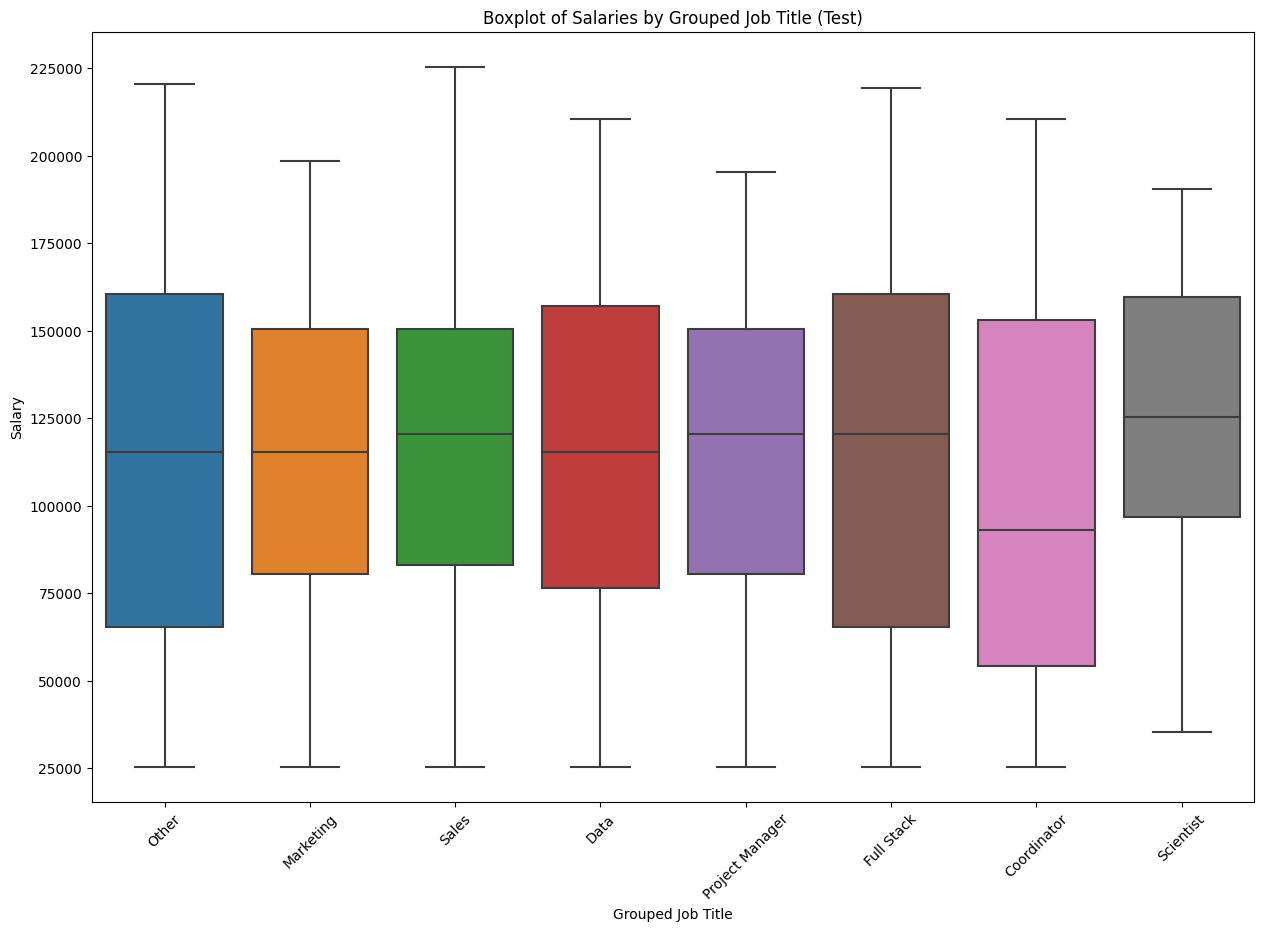

In [601]:
# Create a boxplot 
# As expected, the 'other' group is very variable and probably needs more grouping
plt.figure(figsize=(15, 10))
sns.boxplot(x='Grouped Job Title', y='Salary', data=combined_df_test)
plt.title("Boxplot of Salaries by Grouped Job Title (Test)")
plt.xticks(rotation=45)
plt.show()

In [602]:
# Get rid of jobs that are difficult to classify
# combined_df_test = combined_df_test[combined_df_test['Grouped Job Title'] != 'Other']

In [603]:
# One-hot encode the categorical data (with the same encoder of train data and same columns)
encoded_categorical_data_test = encoder.fit_transform(combined_df_test[categorical_cols])

# Create a DataFrame from the encoded data, with correct column names
encoded_df_test = pd.DataFrame(encoded_categorical_data_test, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with numerical data
final_df_test = pd.concat([encoded_df_test.reset_index(drop=True), combined_df_test[numerical_cols].reset_index(drop=True)], axis=1)

Model Evaluation (Test Dataset)

In [604]:
# Make predictions on the test set
y_test_pred = model.predict(final_df_test)

# Name the y train data
y_test = combined_df_test['Salary']

# Calculate RMSE for the training set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Root Mean Square Error on training data: {rmse_test}')

Root Mean Square Error on training data: 69346.66529205286


Predicted vs Actual

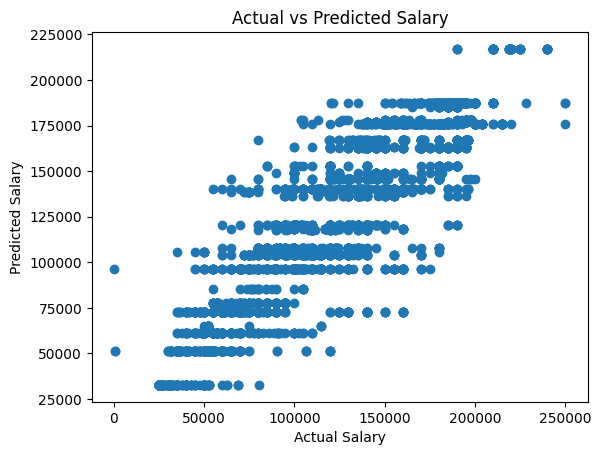

In [605]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salary')
plt.show()

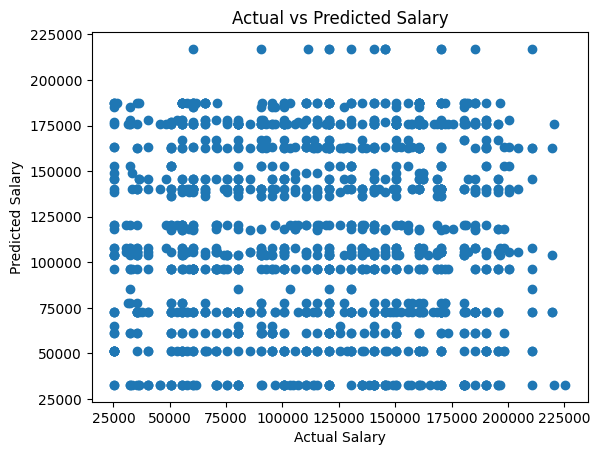

In [606]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salary')
plt.show()

Create a dictionary with the Predicted Values

In [607]:
output_dict = {}
for i, value in enumerate(y_test_pred):
    test_id = i + 1  # Starts from 1
    output_dict[test_id] = value


 Convert Dictionary to JSON File

In [608]:
with open('predictions.json', 'w') as f:
    json.dump(output_dict, f)

In [609]:


'''
Resources:
Naya notebooks
Chat GPT
https://www.youtube.com/watch?v=1fFVt4tQjRE

'''



'\nResources:\nNaya notebooks\nChat GPT\nhttps://www.youtube.com/watch?v=1fFVt4tQjRE\n\n'